In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lib.module.risk_budgeting import *
import student_mixture as sm
from tqdm import tqdm
from Lib.module.movidas import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
np.random.seed(0)

In [6]:
### Import stock price data for model calibration
freq = 'B'
assets = ['JPM UN Equity', 'PFE UN Equity', 'XOM UN Equity']
nb_asset = len(assets)

df_all = pd.concat([pd.read_excel('Data/SP_RC.xlsx',index_col=0, header=[0,1]), pd.read_excel('Data/SP_RC2.xlsx',index_col=0, header=[0,1])])
df_all = df_all.dropna(how='all').dropna(axis=1)
df_all = df_all.pct_change().dropna()
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all[~df_all.index.duplicated(keep='first')]
df = df_all[assets]

X = df.values
print(X.shape)

(3446, 3)


In [7]:
### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)

In [8]:
### Print model parameters 
print("==== Number of assets ====")
print(nb_asset)
print("==== Number of mixture components ====")
print(n_sm)
print("==== Weights (probability) parameters ====")
print(SM_model.weights_)
print("==== Degree of freedom parameters ====")
print(SM_model.dofs_)
print("==== Location parameters ====")
print(SM_model.locations_)
print("==== Scale parameters ====")
print(SM_model.scales_)

==== Number of assets ====
3
==== Number of mixture components ====
2
==== Weights (probability) parameters ====
[0.57536895 0.42463105]
==== Degree of freedom parameters ====
[2.5 4. ]
==== Location parameters ====
[[-0.00070383 -0.00097538 -0.00182552]
 [ 0.00160405  0.00209373  0.00204925]]
==== Scale parameters ====
[[[2.45546634e-04 7.09484995e-05 8.74424168e-05]
  [7.09484995e-05 6.90364583e-05 4.56142046e-05]
  [8.74424168e-05 4.56142046e-05 1.04945729e-04]]

 [[9.06453859e-05 1.79115311e-05 4.41578466e-05]
  [1.79115311e-05 1.24689694e-04 1.80013614e-05]
  [4.41578466e-05 1.80013614e-05 1.06182789e-04]]]


In [9]:
### Compute the Risk Budgeting portfolio under the above model

# ERC
budgets = np.ones(nb_asset)/nb_asset 
# Expected Shortfall alpha
alpha = .95 

SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

print('==== Target Risk Bugdets ====')
print(np.round(budgets, 4))
print('==== $y^*$ ====')
print(np.round(optim_res.x, 4))

print('==== Risk Budgeting portfolio ($u^*$) ====')
print(np.round(SM_theta, 4))
print('==== VaR of the portfolio ====')
print(np.round(VaR_port, 4))
print('==== Expected Shortfall of the portfolio ====')
print(np.round(ES_port, 4))
print('==== Risk Contributions ====')
print(np.round(risk_contribs, 5))
print('==== Risk Contributions (normalized) ====')
print(np.round(risk_contribs/sum(risk_contribs), 2))

==== Target Risk Bugdets ====
[0.3333 0.3333 0.3333]
==== $y^*$ ====
[ 6.9959 11.6543  9.8087]
==== Risk Budgeting portfolio ($u^*$) ====
[0.2458 0.4095 0.3447]
==== VaR of the portfolio ====
0.0202
==== Expected Shortfall of the portfolio ====
0.0351
==== Risk Contributions ====
[0.01171 0.01171 0.01171]
==== Risk Contributions (normalized) ====
[0.33 0.33 0.33]


In [10]:
StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)

(array([0.24582584, 0.40951357, 0.34466059]),
   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
   success: True
    status: 0
       fun: -1.2280854838694133
         x: [ 6.996e+00  1.165e+01  9.809e+00]
       nit: 13
       jac: [ 1.110e-07  2.220e-07  1.332e-07]
      nfev: 56
      njev: 14
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>)

In [46]:
optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))
optimal_loss

-1.2280854838694133

### SMD vs. SGD - Error analysis

In [48]:
np.random.seed(0)

errors_sgd = []
errors_smd = []

for i in tqdm(range(100)):

    n_val=1000000
    X = SM_model.rvs(n_val)
    np.random.shuffle(X)

    alpha = .95
    gamma = 10

    y_sgd = budgets / np.std(X, axis=0)
    xi_sgd = 0
    c_sgd = .65

    y_smd = budgets / np.std(X, axis=0)
    xi_smd = 0
    c_smd = .8
    M = 500

    y_sgd_s = [y_sgd]
    xi_sgd_s = [xi_sgd]
    y_bar_sgd_s = [y_sgd]
    y_bar_sgd_numerator = 0
    y_bar_sgd_denominator = 0

    y_smd_s = [y_smd]
    xi_smd_s = [xi_smd]
    y_bar_smd_s = [y_smd]
    y_bar_smd_numerator = 0
    y_bar_smd_denominator = 0

    error_sgd = []
    error_smd = []

    freq_error = 50

    for k in range(1, n_val):
        x = X[k]
        
        ### SGD
        # gradient
        step_size_sgd = gamma/k**c_sgd
        indicator_sgd = -np.dot(y_sgd, x) - xi_sgd >= 0
        grad_y_sgd = -x/(1-alpha)*indicator_sgd - budgets/y_sgd
        grad_xi_sgd = 1 - (1 / (1 - alpha)) * indicator_sgd

        #descent
        y_sgd = y_sgd - step_size_sgd*grad_y_sgd
        y_sgd = np.where(y <= 0, 1e-04, y_sgd)
        xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
        y_bar_sgd_numerator += y_sgd*step_size_sgd
        y_bar_sgd_denominator += step_size_sgd

        ### SMD
        # gradient
        step_size_smd = gamma/k**c_smd
        indicator_smd = -np.dot(y_smd, x) - xi_smd >= 0
        grad_y_smd = -x/(1-alpha)*indicator_smd - budgets/y_smd
        grad_xi_smd = 1 - (1 / (1 - alpha)) * indicator_smd

        y_smd_min = min(min(y_smd),1)
        y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
        xi_smd = xi_smd - step_size_smd*grad_xi_smd
        sum_y_smd = np.sum(y_smd)
        if sum_y_smd>M:
            y_smd = M/sum_y_smd*y_smd
        y_bar_smd_numerator += y_smd*step_size_smd
        y_bar_smd_denominator += step_size_smd

        # y_sgd_s.append(y_sgd)
        # xi_sgd_s.append(xi_sgd)
        # y_bar_sgd_s.append(y_bar_sgd_numerator/y_bar_sgd_denominator)

        # y_smd_s.append(y_smd)
        # xi_smd_s.append(xi_smd)
        # y_bar_smd_s.append(y_bar_smd_numerator/y_bar_smd_denominator)

        if k%freq_error==0:
            error_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss)
            error_smd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd, alpha) - np.dot(budgets, np.log(y_smd)) - optimal_loss)
    
    errors_sgd.append(error_sgd)
    errors_smd.append(error_smd)

    np.save('sgd_errors.npy', np.array(errors_sgd))
    np.save('smd_errors.npy', np.array(errors_smd))

 29%|██▉       | 29/100 [1:36:57<5:11:47, 263.49s/it]C:\Users\arcetingoz\AppData\Local\Temp\ipykernel_1112\1483225849.py:82: RuntimeWarning: invalid value encountered in log
  error_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss)
 97%|█████████▋| 97/100 [5:29:53<10:12, 204.05s/it]  


KeyboardInterrupt: 

In [40]:
errors_sgd = []
errors_smd = []
for i in tqdm(ns):
    errors_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd_s[i], alpha) - np.dot(budgets, np.log(y_sgd_s[i])) - optimal_loss)
    errors_smd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd_s[i], alpha) - np.dot(budgets, np.log(y_smd_s[i])) - optimal_loss)

100%|██████████| 20000/20000 [01:53<00:00, 175.67it/s]


In [41]:
errors_sgd_bar = []
errors_smd_bar = []
for i in tqdm(ns):
    errors_sgd_bar.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_bar_sgd_s[i], alpha) - np.dot(budgets, np.log(y_bar_sgd_s[i])) - optimal_loss)
    errors_smd_bar.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_bar_smd_s[i], alpha) - np.dot(budgets, np.log(y_bar_smd_s[i])) - optimal_loss)

100%|██████████| 20000/20000 [01:57<00:00, 169.55it/s]


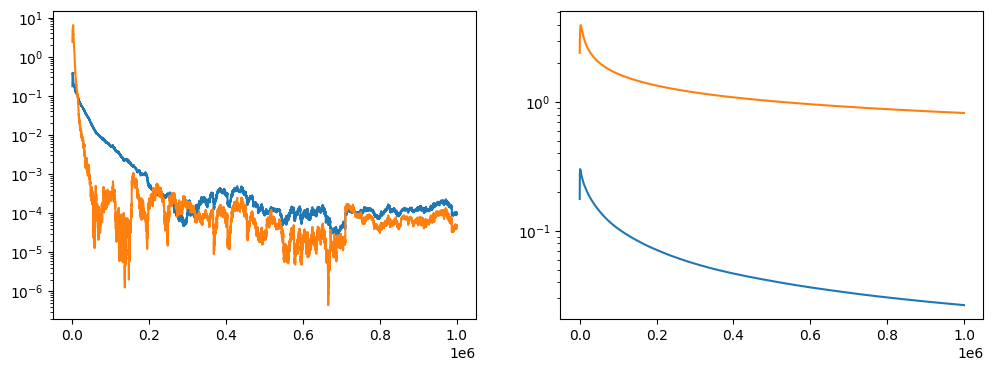

In [45]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ns, errors_sgd);
ax[0].plot(ns, errors_smd);
ax[0].set_yscale('log')

ax[1].plot(ns, errors_sgd_bar);
ax[1].plot(ns, errors_smd_bar);
ax[1].set_yscale('log')

In [54]:
y_sgd_s[-1]/sum(y_sgd_s[-1])

array([0.24316013, 0.40984939, 0.34699048])

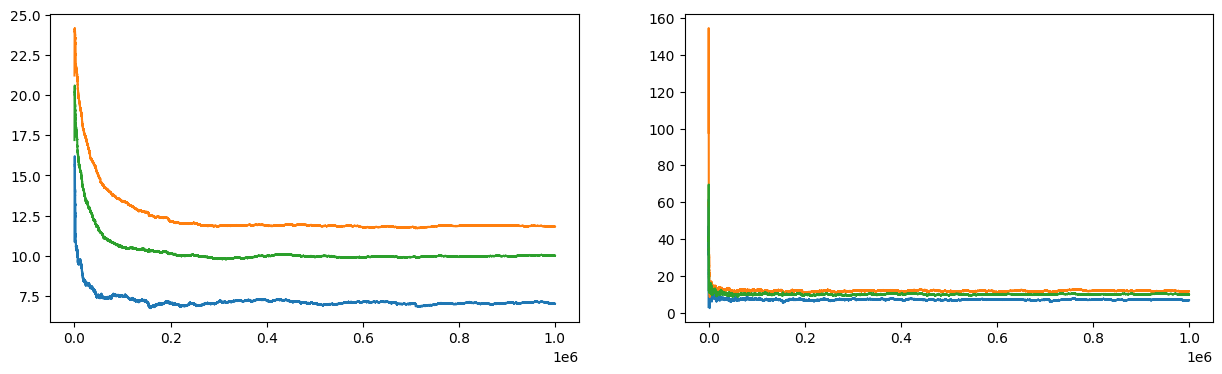

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);

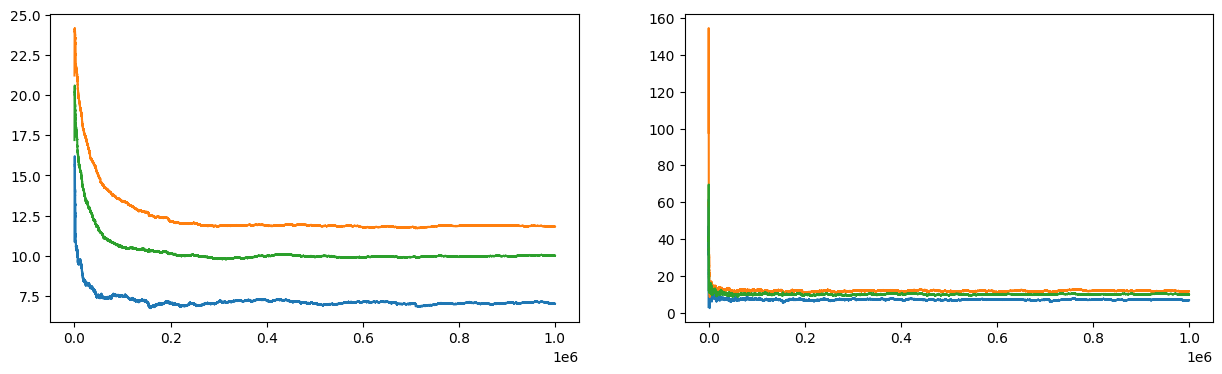

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);

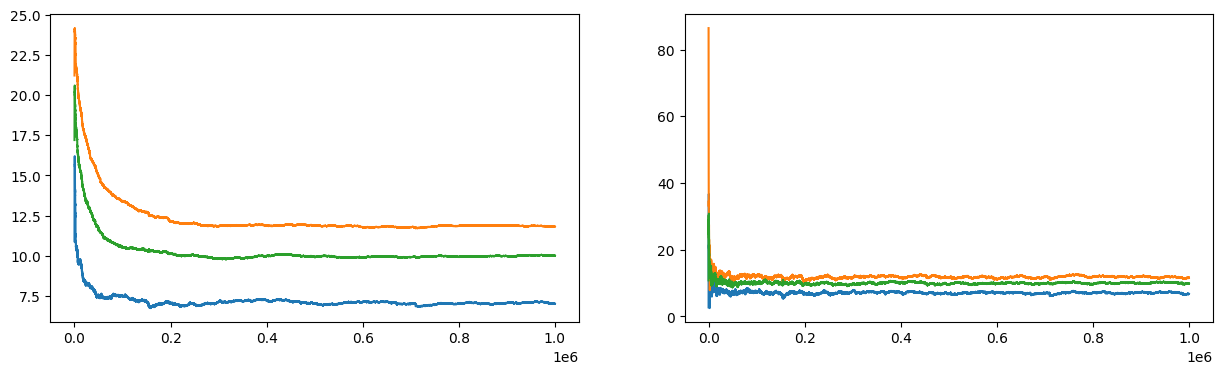

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);


In [37]:
y_sgd_s[-1]

array([ 7.00890287, 11.81359223, 10.00173283])

In [38]:
y_smd_s[-1]

array([ 6.75119649, 11.65253988,  9.8515459 ])

==== True Risk Budgeting portfolio ====
[0.2458 0.4095 0.3447]
==== Risk Budgeting portfolio from SGD ====
[0.2442 0.4098 0.346 ]
CPU times: total: 34.5 s
Wall time: 35.1 s


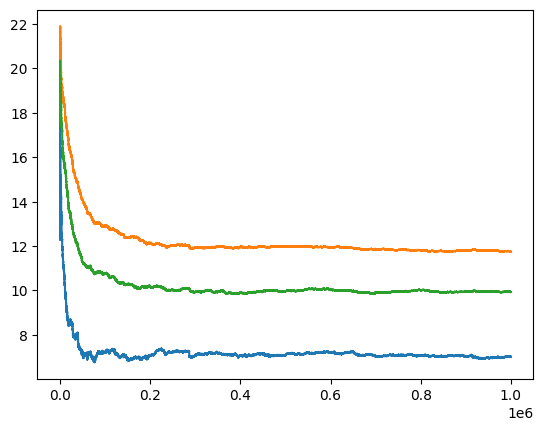

In [10]:
%%time
# we define our risk budgeting problem for expected shortfall
rb = RiskBudgeting(risk_measure='expected_shortfall',
                   alpha=0.95,
                   budgets='ERC')
rb.solve(X, 
         epochs=1,
         minibatch_size=1,
         eta_0_y=10, 
         eta_0_t=10,
         c=0.65,
         polyak_ruppert=0.2,
         store=True)

print('==== True Risk Budgeting portfolio ====')
print(np.round(SM_theta, 4))
print('==== Risk Budgeting portfolio from SGD ====')
print(np.round(rb.x, 4))

plt.plot(rb.ys);

In [27]:
%%time
M=30
rb_md = stoch_sol(X, M, n_val, nb_asset, budgets, n_epochs=1, gamma=10)

100%|██████████| 1/1 [00:43<00:00, 43.86s/it]

CPU times: total: 43 s
Wall time: 43.9 s


#### Error analysis

In [23]:
y_s = np.array(rb.ys)
x,y,z = np.array(rb_md.y_bars).shape
y_s_md = np.array(rb_md.y_bars).reshape(x,z)
optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))
optimal_loss

-1.2280854838694133

In [24]:
errors = []
errors_md = []
for i in tqdm(range(0,len(y_s)-1,100)):
    errors.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s[i], alpha) - np.dot(budgets, np.log(y_s[i])) - optimal_loss)
    errors_md.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s_md[i], alpha) - np.dot(budgets, np.log(y_s_md[i])) - optimal_loss)

100%|██████████| 10000/10000 [00:43<00:00, 232.36it/s]


In [51]:
len(y_s)

1000001

In [52]:
len(y_s_md)

1000000

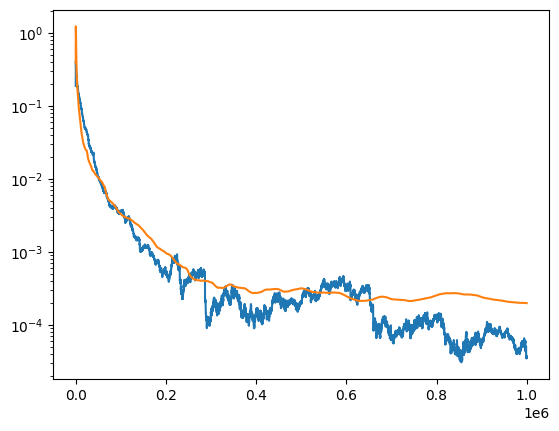

In [25]:
plt.plot(range(0,len(y_s)-1,100), errors)
plt.plot(range(0,len(y_s)-1,100), errors_md)
plt.yscale('log')

In [46]:
min(errors)

1.9125464545410864e-08

In [37]:
y_s

array([[12.28042621, 19.61747494, 17.56669541],
       [13.63759952, 20.46705761, 18.51546047],
       [14.41642709, 20.9860056 , 19.08910748],
       ...,
       [ 7.05348165, 11.64680376,  9.9984121 ],
       [ 7.05377912, 11.64698391,  9.99862196],
       [ 7.05407658, 11.64716406,  9.99883181]])

In [23]:
%%time
M=50
solution_md = stoch_sol(X, M, n_val, nb_asset, budgets, n_epochs=1)

100%|██████████| 1/1 [00:26<00:00, 26.40s/it]

CPU times: total: 25.8 s
Wall time: 26.4 s


In [26]:
y_s_md = solution_md.ys.T

In [28]:
errors_md = []
for i in tqdm(range(0,len(y_s_md),50)):
    errors_md.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s_md[i], alpha) - np.dot(budgets, np.log(y_s_md[i])) - optimal_loss)
    

100%|██████████| 20000/20000 [00:41<00:00, 482.90it/s]


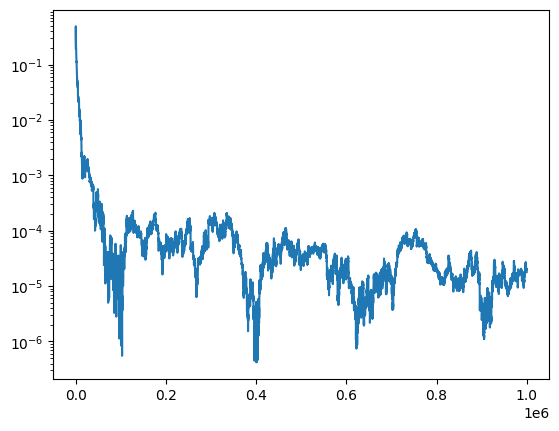

In [31]:
plt.plot(range(0,len(y_s_md),50), errors_md)
plt.yscale('log')